In [ ]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D, LSTM, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.tokenize import word_tokenize
import re

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Clean text function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

In [ ]:
def load_imdb_data():
    imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

    train_data = imdb['train']
    train_sentences, train_labels = [], []

    for sentence, label in tfds.as_numpy(train_data):
        train_sentences.append(clean_text(sentence.decode('utf-8')))
        train_labels.append(int(label))

    test_data = imdb['test']
    test_sentences = []
    test_labels = []

    for sentence, label in tfds.as_numpy(test_data):
        test_sentences.append(clean_text(sentence.decode('utf-8')))
        test_labels.append(int(label))

    return train_sentences, train_labels, test_sentences, test_labels

In [ ]:
train_sentences, train_labels, test_sentences, test_labels = load_imdb_data()

max_len = 100
embedding_dim = 128
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_sentences)

#additional steps start (compared with Ex 7 summarization)
tokenized_sentences = [sentence.split() for sentence in train_sentences] #convert sentences into list of words for word2vec


word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=embedding_dim, window=5, min_count=1, sg=0) #sg=0 means CBOW model sg=1 means skip gram model, window = 5 means window context

word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

#additional steps end ( all of this step to get embedding_matrix )

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')

train_labels = np.array(train_labels)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2P6VBH_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2P6VBH_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2P6VBH_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
model = Sequential()

model.add(Embedding(max_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_len, trainable=False)) #embeddings_initializer=Constant(embedding_matrix) is additional
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=2, batch_size=128, validation_data=(X_val, y_val), verbose=1)

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.6441 - loss: 0.6162 - val_accuracy: 0.8100 - val_loss: 0.4088
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8251 - loss: 0.4044 - val_accuracy: 0.8298 - val_loss: 0.3815


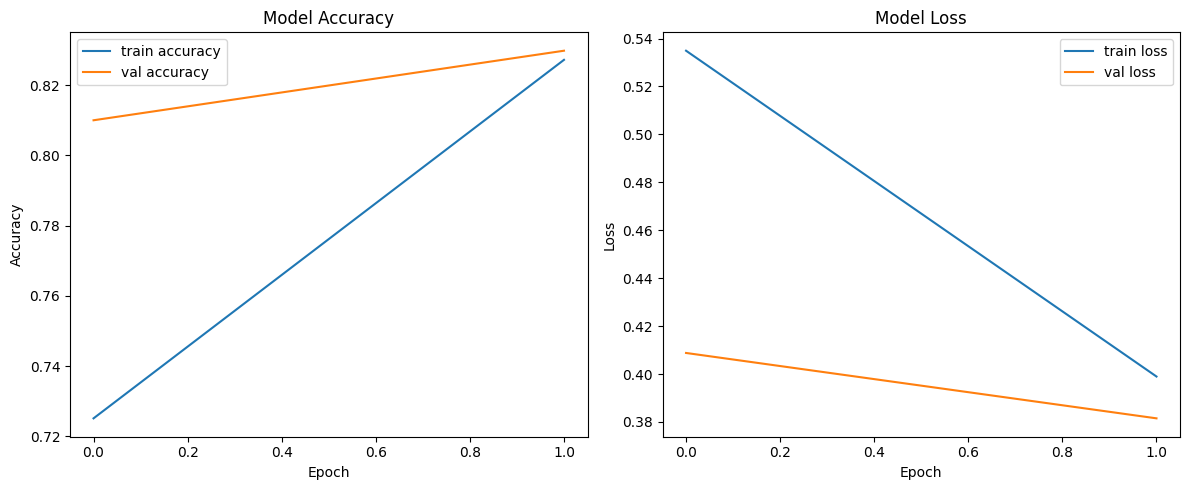

In [ ]:
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

y_pred = (model.predict(test_padded) > 0.5).astype("int32")

print(classification_report(test_labels, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
              precision    recall  f1-score   support

           0       0.85      0.75      0.79     12500
           1       0.77      0.86      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

